In [7]:
import string
import pandas as pd
import pyphen
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
dic = pyphen.Pyphen(lang='de')
import spacy
nlp = spacy.load("de_core_news_md")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# Data source


In [9]:
df = pd.read_csv("all_preprocessed.csv")
df.head(5)

,Unnamed: 0,speaker,raw_text,group,gender,is_depressed,couple_id,sent_count,word_count,lemmatized,stopwords_removed,normalized_text
0,0,A,Positive Gefühle.,1,M,False,27,1,2,positiv gefühle,positiv gefühle,positiv gefühle
1,1,A,"(A zieht seine Brille auf) Zuwendung, das ist ...",1,M,False,27,3,72,zuwendung das sein ja zuwendung wir beide wenn...,zuwendung zuwendung zuwenden fühlen verteilung...,zuwendung das sein ja zuwendung wir beide wenn...
2,2,B,"Wir lieben beide Kinder, [A: Ja] und die liebe...",1,W,True,27,4,29,wir lieb beid kinder a ja und die lieb uns von...,lieb beid kinder lieb schön kinder kinder beha...,wir lieb beid kinder a ja und die lieb uns von...
3,3,A,"Es tut gut, und mir tut´s auch gut sie zu beha...",1,M,False,27,1,13,es tun gut und mir tun ´ s auch gut sie zu beh...,´ s behandeln,es tun gut und mir tun ´ s auch gut sie zu beh...
4,4,B,"Auch, wie ich dich liebe, dann liebe ich auch ...",1,W,True,27,1,18,auch wie ich dich lieb dann lieb ich auch mein...,lieb lieb verwandtschaft willkommen,auch wie ich dich lieb dann lieb ich auch mein...


# Basic Statistis

word count depressed, non-d

# TFIDF

## Corpus level - Depressed couples vs. non-depressed couples

Here we compare the TFIDF on the entire corpus comparing all depressed couples with all non-depressed couples.


<AxesSubplot:>

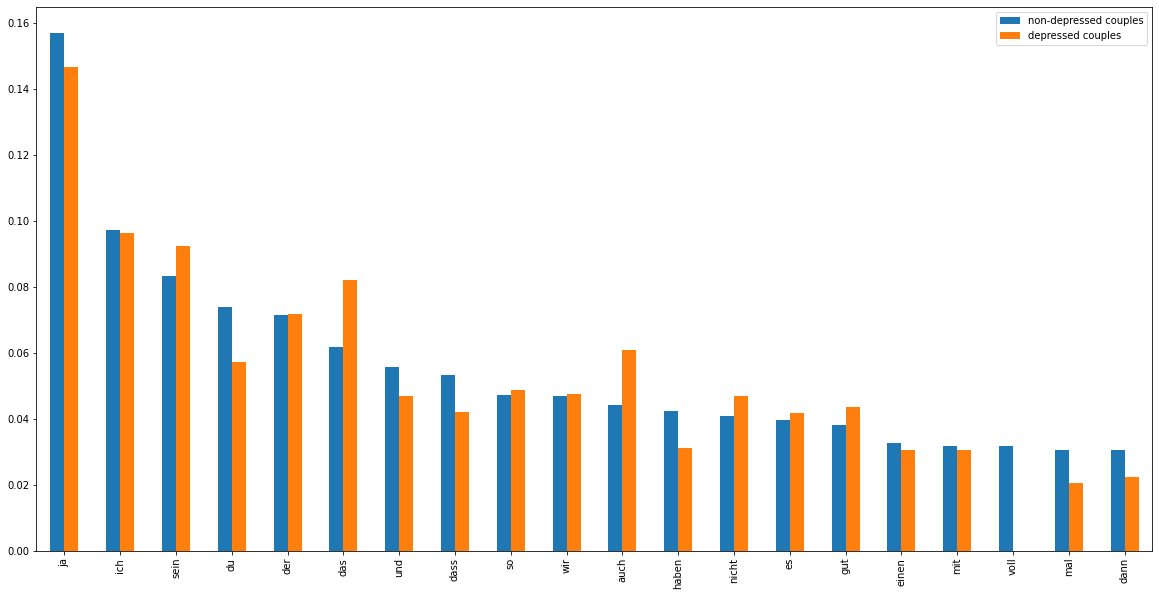

In [11]:
def get_tfidf(dataframe):
    
    # get vectors with frequencies for the words in the lines; each line is considered a document; remove stop words with stop-word-list from scikit-learn; exclude words with frequency smaller 5
    count_vectorizer = CountVectorizer(min_df=5)
    count_vectorized = count_vectorizer.fit_transform(dataframe)

    # transform the vector-frequency matrix in tfidf 
    tfidf_transformer = TfidfTransformer(use_idf=True)
    tfidf = tfidf_transformer.fit_transform(count_vectorized)

    # create new dataframe with tfidfs and the feature names; calculate the mean tfidf over all lines/documents
    df_tfidf = pd.DataFrame(tfidf.T.todense(), index = count_vectorizer.get_feature_names())
    df_tfidf['mean'] = df_tfidf.mean(axis=1)
    df_tfidf = df_tfidf.sort_values('mean', ascending=False)

    return df_tfidf['mean']


non_depressed_couples = df.loc[(df['group'] == 0)]['normalized_text'].dropna()
depressed_couples = df.loc[(df['group'] == 1)]['normalized_text'].dropna()

# get tfidf scores per line
df_tfidf_non_depressed_couples = get_tfidf(non_depressed_couples)
df_tfidf_depressed_couples = get_tfidf(depressed_couples)
df_tfidf = pd.concat([df_tfidf_non_depressed_couples, df_tfidf_depressed_couples], keys=['non-depressed couples', 'depressed couples'], axis=1)
df_tfidf.head(20).plot(kind='bar', figsize=(20,10))

### Corpus level - Depressed persons vs. non-depressed persons

<AxesSubplot:>

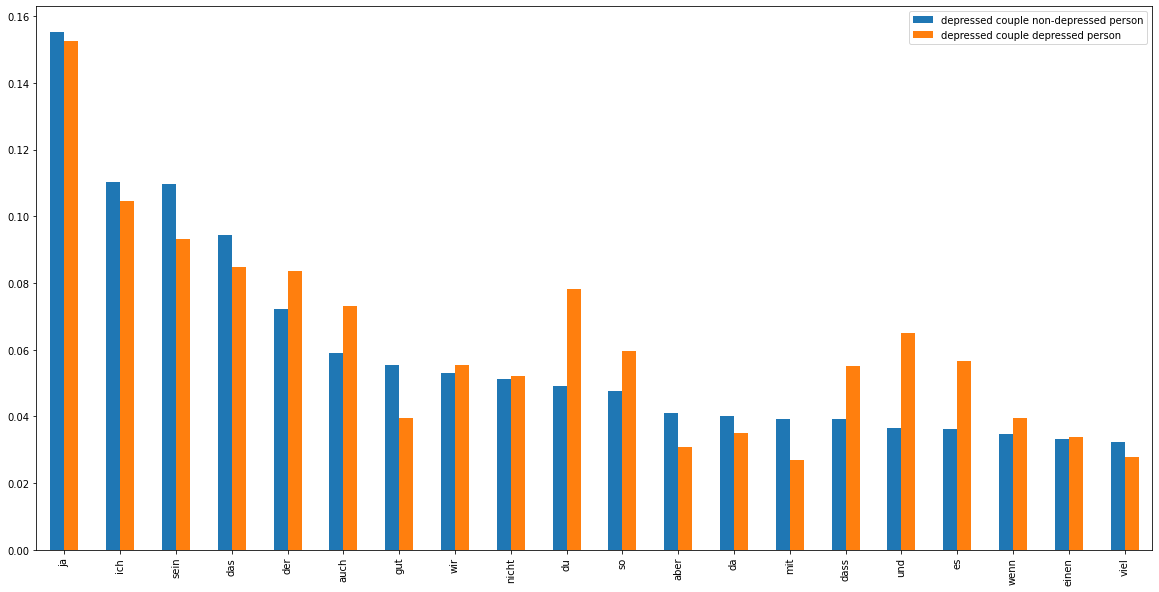

In [13]:

depressed_couple_non_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == False)]['normalized_text'].dropna()
depressed_couple_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == True)]['normalized_text'].dropna()

# get tfidf scores per line
df_tfidf_depressed_couple_non_depressed_person = get_tfidf(depressed_couple_non_depressed_person)
df_tfidf_depressed_couple_depressed_person = get_tfidf(depressed_couple_depressed_person)

# plot results
df_tfidf = pd.concat([df_tfidf_depressed_couple_non_depressed_person, df_tfidf_depressed_couple_depressed_person], keys=['depressed couple non-depressed person', 'depressed couple depressed person'], axis=1)
df_tfidf.head(20).plot(kind='bar', figsize=(20,10))

# POS Tagging

## Corpus Level - Depressed couples vs non-depressed couples

Here we compare the POS on the entire corpus comparing all depressed couples with all non-depressed couples.


<AxesSubplot:>

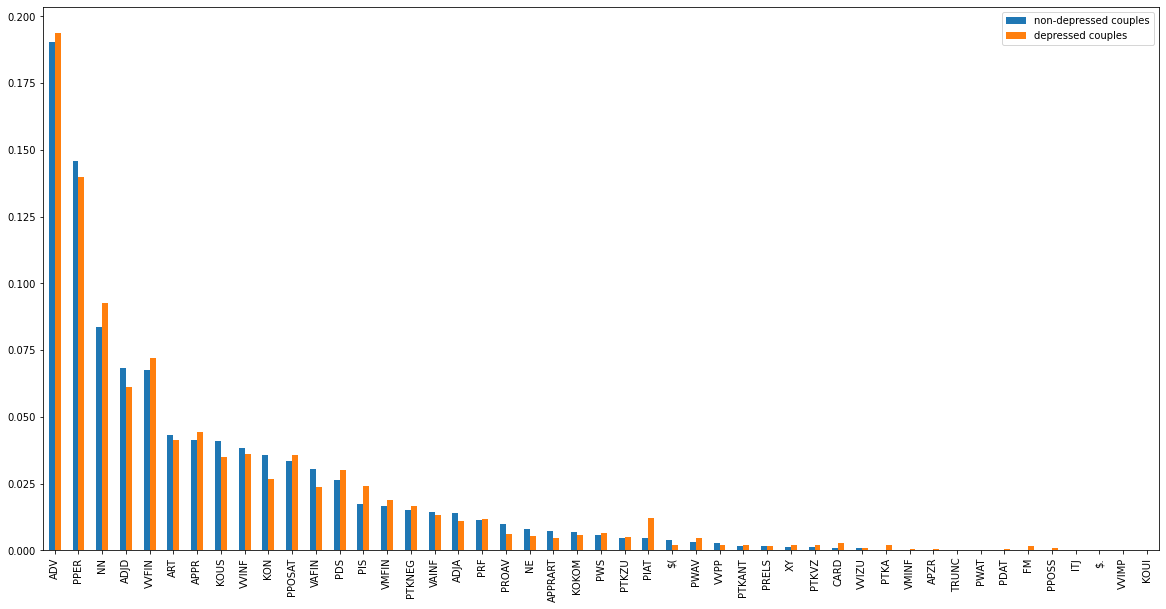

In [15]:
# POS tagging with spacy 
def get_pos(dataframe):
    
    df_as_string = ' '.join(dataframe.tolist())
    
    doc = nlp(df_as_string)
    
    pos = []
    [pos.append(word.tag_) for word in doc]

    return pos

# get POS for non-depressed couples
non_depressed_couples = df.loc[(df['group'] == 0)]['normalized_text'].dropna()
pos_non_depressed_couples = get_pos(non_depressed_couples)
pos_non_depressed_couples_summary = pd.DataFrame(pos_non_depressed_couples, columns=['non-depressed couples']).apply(pd.value_counts).div(len(pos_non_depressed_couples))

# get POS for depressed couples
depressed_couples = df.loc[(df['group'] == 1)]['normalized_text'].dropna()
pos_depressed_couples = get_pos(depressed_couples)
pos_depressed_couples_summary = pd.DataFrame(pos_depressed_couples, columns=['depressed couples']).apply(pd.value_counts).div(len(pos_depressed_couples))

# plot
pos_summary = pd.concat([pos_non_depressed_couples_summary, pos_depressed_couples_summary], axis=1)
pos_summary.plot(kind='bar', figsize=(20,10))


In [34]:
pos_depressed_couples_summary = pd.DataFrame(pos_depressed_couples).apply(pd.value_counts).div(len(pos_depressed_couples)).sort_index()
dict(zip(pos_depressed_couples_summary.index,pos_depressed_couples_summary.values[:,0]))

{'$(': 0.0020480357475330477,
 '$.': 0.0001861850679575498,
 'ADJA': 0.010984919009495438,
 'ADJD': 0.061068702290076333,
 'ADV': 0.19381865574380935,
 'APPR': 0.044498231241854404,
 'APPRART': 0.004654626698938745,
 'APZR': 0.0005585552038726494,
 'ART': 0.04133308508657606,
 'CARD': 0.002792776019363247,
 'FM': 0.0016756656116179481,
 'ITJ': 0.0001861850679575498,
 'KOKOM': 0.005957922174641594,
 'KON': 0.026624464717929622,
 'KOUI': 0.0001861850679575498,
 'KOUS': 0.035002792776019365,
 'NE': 0.005585552038726494,
 'NN': 0.09253397877490226,
 'PDAT': 0.0003723701359150996,
 'PDS': 0.030161981009123068,
 'PIAT': 0.012102029417240737,
 'PIS': 0.024204058834481474,
 'PPER': 0.1398249860361199,
 'PPOSAT': 0.03574753304784956,
 'PPOSS': 0.0007447402718301992,
 'PRELS': 0.0014894805436603984,
 'PRF': 0.011915844349283188,
 'PROAV': 0.006330292310556694,
 'PTKA': 0.001861850679575498,
 'PTKANT': 0.001861850679575498,
 'PTKNEG': 0.016570471048221933,
 'PTKVZ': 0.001861850679575498,
 'PTKZU'

## Corpus Level - Depressed persons vs non-depressed persons

Here we compare the POS on the entire corpus comparing all depressed perons with all non-depressed persons.


<AxesSubplot:>

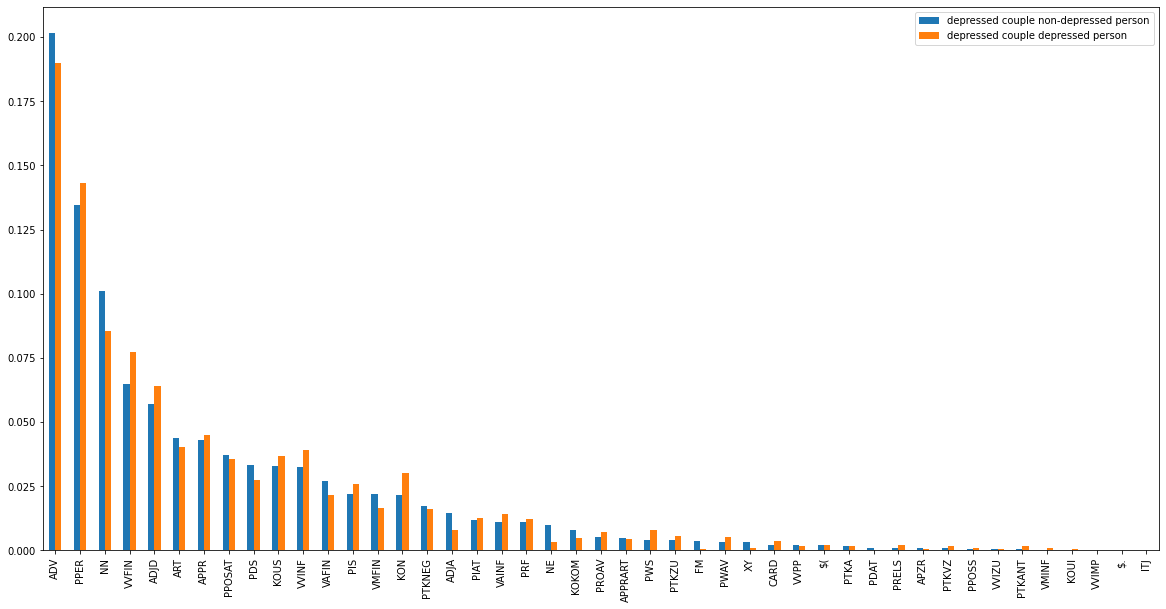

In [53]:
# get POS for non-depressive person of a depressed couple
depressed_couple_non_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == False)]['normalized_text'].dropna()
pos_depressed_couple_non_depressed_person = get_pos(depressed_couple_non_depressed_person)
pos_depressed_couple_non_depressed_person_summary = pd.DataFrame(pos_depressed_couple_non_depressed_person, columns=['depressed couple non-depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_non_depressed_person))

# get POS for depressive person of a depressed couple
depressed_couple_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == True)]['normalized_text'].dropna()
pos_depressed_couple_depressed_person = get_pos(depressed_couple_depressed_person)
pos_depressed_couple_depressed_person_summary = pd.DataFrame(pos_depressed_couple_depressed_person, columns=['depressed couple depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_depressed_person))

# plot
pos_summary = pd.concat([pos_depressed_couple_non_depressed_person_summary, pos_depressed_couple_depressed_person_summary], axis=1)
pos_summary.plot(kind='bar', figsize=(20,10))

## Document level

### Comparison of both partners in depressed couples and not depressed couples

In [130]:
couples_ids = df.couple_id.value_counts().index.sort_values().values

depressed_couples = list()
non_depressed_couples = list()

for id in couples_ids:

    # depressed couples -> if depression group
    if(df.loc[(df['couple_id'] == id)]['group'].value_counts().index.values[0] == 1):
        depressed_couple_depressed_person = df.loc[(df['couple_id'] == id) & (df['group'] == 1) & (df['gender'] == 'W')]['normalized_text'].dropna().tolist()
        depressed_couple_depressed_person_string = ' '.join(depressed_couple_depressed_person)
        
        depressed_couple_non_depressed_person = df.loc[(df['couple_id'] == id) & (df['group'] == 1) & (df['gender'] == 'M')]['normalized_text'].dropna().tolist()
        depressed_couple_non_depressed_person_string = ' '.join(depressed_couple_non_depressed_person)

        doc_depressed_couple_depressed_person = nlp(depressed_couple_depressed_person_string)
        doc_depressed_couple_non_depressed_person = nlp(depressed_couple_non_depressed_person_string)

        pos_depressed_couple_depressed_person = []
        [pos_depressed_couple_depressed_person.append(doc.tag_) for doc in doc_depressed_couple_depressed_person]

        pos_depressed_couple_non_depressed_person = []
        [pos_depressed_couple_non_depressed_person.append(doc.tag_) for doc in doc_depressed_couple_non_depressed_person]

        pos_depressed_couple_depressed_person_summary = pd.DataFrame(pos_depressed_couple_depressed_person, columns=['depressed couple, depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_depressed_person))
        pos_depressed_couple_non_depressed_person_summary = pd.DataFrame(pos_depressed_couple_non_depressed_person, columns=['depressed couple, non-depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_non_depressed_person))
        pos_summary = pd.concat([pos_depressed_couple_depressed_person_summary, pos_depressed_couple_non_depressed_person_summary], axis=1)
            
        depressed_couples.append((id, pos_summary))

    # non-depressed couples
    elif(df.loc[(df['couple_id'] == id)]['group'].value_counts().index.values[0] == 0):
        non_depressed_couple_person1 = df.loc[(df['couple_id'] == id) & (df['group'] == 0) & (df['gender'] == 'W')]['normalized_text'].dropna().tolist()
        non_depressed_couple_person1_string = ' '.join(non_depressed_couple_person1)
        
        non_depressed_couple_person2 = df.loc[(df['couple_id'] == id) & (df['group'] == 0) & (df['gender'] == 'M')]['normalized_text'].dropna().tolist()
        non_depressed_couple_person2_string = ' '.join(non_depressed_couple_person2)

        doc_non_depressed_couple_person1 = nlp(non_depressed_couple_person1_string)
        doc_non_depressed_couple_person2 = nlp(non_depressed_couple_person2_string)

        pos_non_depressed_couple_person1= []
        [pos_non_depressed_couple_person1.append(doc.tag_) for doc in doc_non_depressed_couple_person1]

        pos_non_depressed_couple_person2 = []
        [pos_non_depressed_couple_person2.append(doc.tag_) for doc in doc_non_depressed_couple_person2]

        pos_non_depressed_couple_person1_summary = pd.DataFrame(pos_non_depressed_couple_person1, columns=['non-depressed couple, person 1']).apply(pd.value_counts).div(len(pos_non_depressed_couple_person1))
        pos_non_depressed_couple_person2_summary = pd.DataFrame(pos_non_depressed_couple_person2, columns=['non-depressed couple, person 2']).apply(pd.value_counts).div(len(pos_non_depressed_couple_person2))
        pos_summary = pd.concat([pos_non_depressed_couple_person1_summary, pos_non_depressed_couple_person2_summary], axis=1)
            
        non_depressed_couples.append((id, pos_summary))



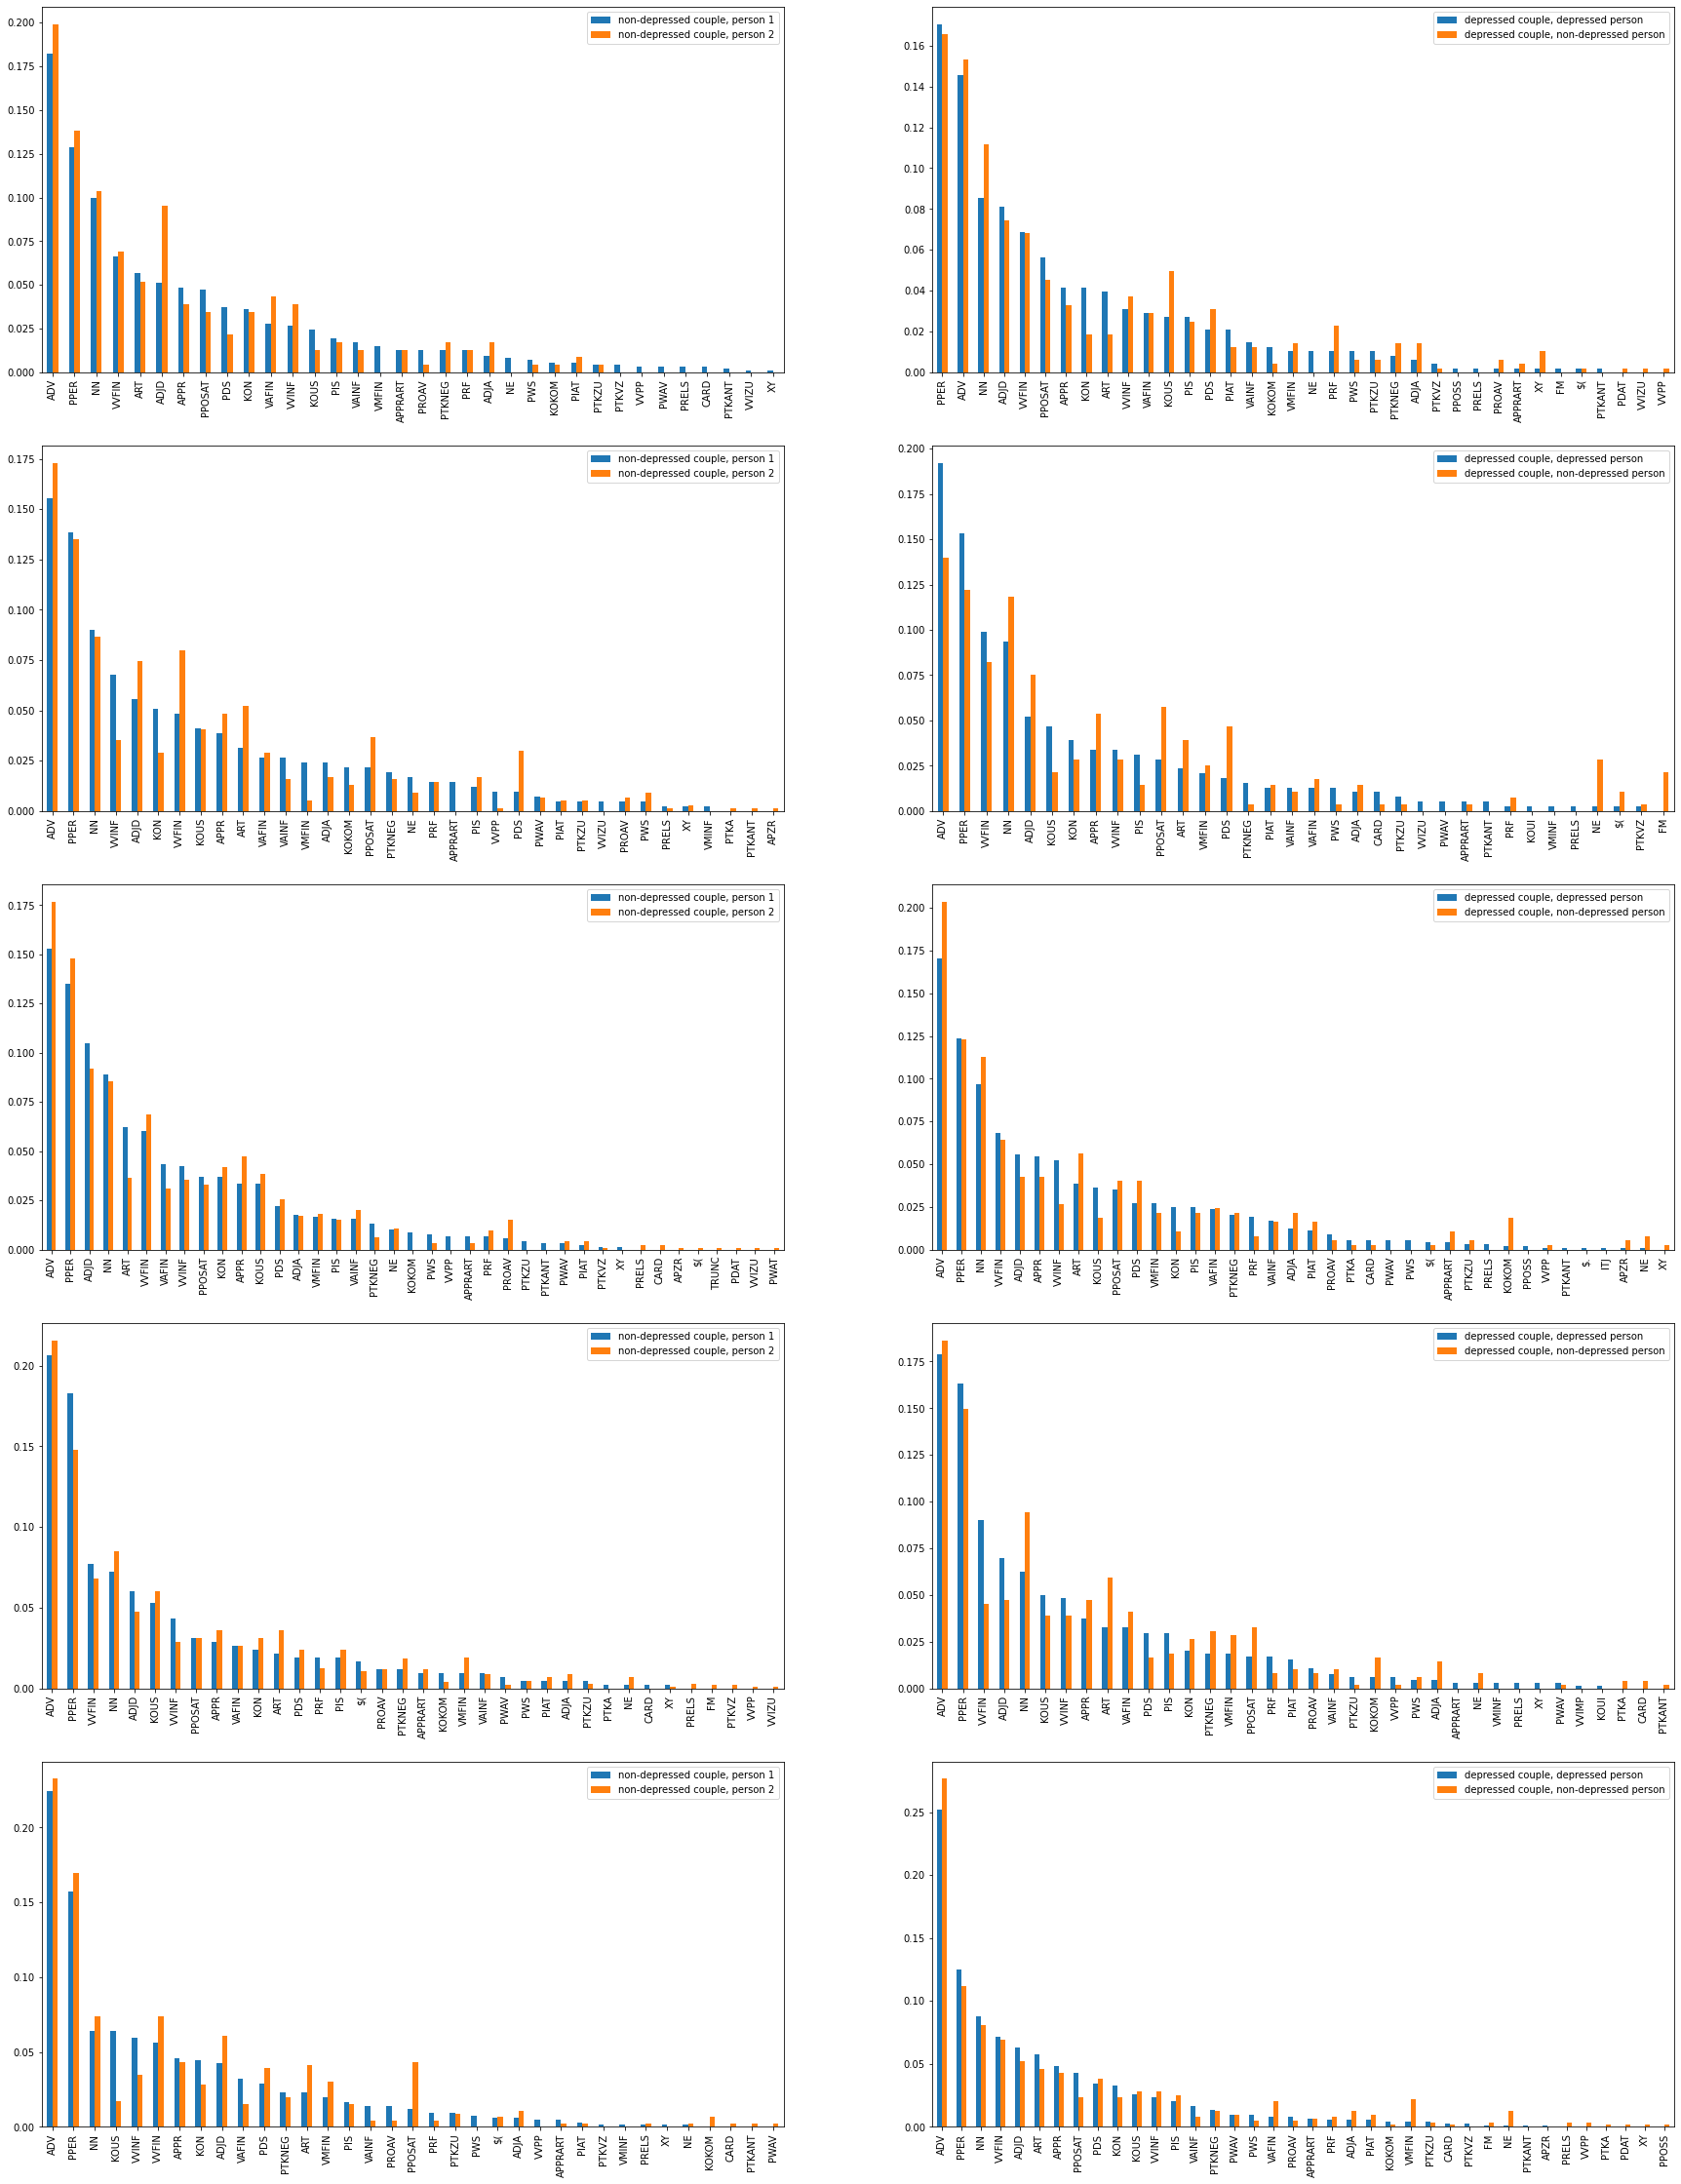

In [131]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30, 40))

for i in range(len(non_depressed_couples)):
    non_depressed_couples[i][1].plot(kind='bar', ax=axes[i,0])
for i in range(len(depressed_couples)):
    depressed_couples[i][1].plot(kind='bar', ax=axes[i,1])